In [1]:
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import torch
import json
import os
import re

In [2]:
def map_phone(phones):
    mapped_phone = []
    for phone in phones:
        if phone == "SCHWA" or phone == "AH0":
            mapped_phone.append("AX")
        else:
            mapped_phone.append(phone)
    
    return mapped_phone

def get_phone_pure(phones):
    pure_phones = [re.sub(r"\d", "", phone) for phone in phones]

    return pure_phones

def preprocess_metadata(metadata):
    metadata = metadata[
        ["id", "audio_path", "text", "arpas", "trans", "phone_scores", "word_scores", "word_ids", "utterance_score"]
    ]
    metadata["id"] = metadata.id.apply(str)
    metadata = metadata.rename(columns={"arpas":"elsa_phone"})
    metadata["elsa_phone"] = metadata.elsa_phone.apply(map_phone)
    metadata["elsa_phone"] = metadata.elsa_phone.apply(get_phone_pure)
    metadata["trans"] = metadata.trans.apply(map_phone)

    return metadata

def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        lines = [json.loads(line.strip()) for line in lines]
    
    lines = pd.DataFrame(lines)
    return lines

def load_gops(gop_paths):
    gops = {}
    for path in gop_paths:
        try:
            gop = pickle.load(open(path, "rb"))
        except:
            continue
        
        for key in gop.keys():
            assert key not in gops

        gops.update(gop)

    return gops

In [3]:
# metadata_path = "/data/codes/apa/train/prep_data/jsonl/train-data-type-12-v2.jsonl"
# out_dir = "/data/codes/apa/train/exps/features/train/train-12"
# data_dir = "/data/codes/apa/train/data/train/train-type-12"

# metadata_path = "/data/codes/apa/train/prep_data/jsonl/info_out_domain_long_sentence_testset.jsonl"
# out_dir = "/data/codes/apa/train/exps/features/test/dev"
# data_dir = "/data/codes/apa/train/data/test/out-long"

# metadata_path = "/data/codes/apa/train/prep_data/jsonl/info_in_domain_long_sentence_testset.jsonl"
# out_dir = "/data/codes/apa/train/exps/features/test/info_in_domain_long_sentence_testset"
# data_dir = "/data/codes/apa/train/data/test/info_in_domain_long_sentence_testset"

# metadata_path = "/data/codes/apa/train/prep_data/jsonl/info_out_domain_short_sentence_testset.jsonl"
# out_dir = "/data/codes/apa/train/exps/features/test/out-short"
# data_dir = "/data/codes/apa/train/data/test/out-short"

metadata_path = "/data/codes/apa/train/data/metadata/jsonl/train-data-type-9.jsonl"
out_dir = "/data/codes/apa/train/data/feats/train/train-data-type-9"
data_dir = "/data/codes/apa/train/data/train/train-data-type-9"

metadata = load_jsonl(metadata_path)
metadata = preprocess_metadata(metadata)
print(metadata.shape)
metadata.head(1)

/tmp/ipykernel_812143/3694442826.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["id"] = metadata.id.apply(str)


(40349, 9)


,id,audio_path,text,elsa_phone,trans,phone_scores,word_scores,word_ids,utterance_score
0,5796046-1,data/metadata/wav/5796046-1.wav,A A A VERY SOLID GO WHEN I WAS A KID,"[AX, AX, AX, V, EH, R, IY, S, AA, L, IH, D, G,...","[AX, AX, AX, V, EH, R, IY, S, AA, L, IH, D, G,...","[44, 17, 31, 93, 99, 98, 96, 90, 1, 100, 86, 0...","[44, 17, 30, 94, 35, 95, 95, 95, 95, 95, 71]","[0, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 6, ...",70.28


In [4]:
# import shutil
# from pandarallel import pandarallel

# pandarallel.initialize(nb_workers=8, progress_bar=True)
# out_path = "/data/codes/apa/train/data/wav"

# def copy_audio(audio_path):
#     dst = f'{out_path}/{os.path.basename(audio_path)}'

#     shutil.copy(src=audio_path, dst=dst)

# metadata.audio_path.parallel_apply(copy_audio)

In [5]:
if out_dir.endswith("-filtered"):
    id_path = f"{out_dir}/id"

    id_df = pd.read_csv(id_path, names=["id"], dtype={'id':str})
    id_df = id_df.set_index("id")

    print(metadata.shape)
    metadata = metadata[metadata.id.isin(id_df.index)]
    print(metadata.shape)

In [6]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
gop_path = f'{data_dir}/*/gop.pkl'
align_path = f'{data_dir}/*/ali.out'

alignment_paths = glob(align_path)
gop_paths = glob(gop_path)

In [7]:
def load_alignment(path):
    alignment_df = pd.read_csv(
        path, names=["id", "alignment"], sep="\t", dtype={"id": str}
    )
    alignment_df["alignment"] = alignment_df.alignment.apply(json.loads)

    return alignment_df

def load_alignments(paths):
    alignments = []
    for path in paths:
        alignment = load_alignment(path)
        alignments.append(alignment)
    
    alignments = pd.concat(alignments)
    alignments.reset_index(inplace=True)

    return alignments[["id", "alignment"]]

alignments = load_alignments(alignment_paths)
gops = load_gops(gop_paths)

In [8]:
is_valid = alignments.id.apply(lambda x: x in gops)
print(alignments.shape)
alignments = alignments[is_valid]
print(alignments.shape)

(40340, 2)
(40340, 2)


In [9]:
def extract_phonemes(alignments):
    phonemes = [
        re.sub("\d", "",phoneme[0].split("_")[0]) for phoneme in alignments
        if phoneme[0] != "SIL"
    ]
    return phonemes

def extract_durations(alignments):
    durations = [
        round(phoneme[2] * 0.02, 4) for phoneme in alignments
        if phoneme[0] != "SIL"
    ]
    return durations

def extract_relative_positions(alignments):
    relative_positions = [
        phoneme[0].split("_")[-1] for phoneme in alignments
        if phoneme[0] != "SIL"
    ]
    return relative_positions


alignments["relative_positions"] = alignments.alignment.apply(lambda x: extract_relative_positions(x))
alignments["prep_phone"] = alignments.alignment.apply(lambda x: extract_phonemes(x))
alignments["duration"] = alignments.alignment.apply(lambda x: extract_durations(x))

In [10]:
metadata = pd.merge(
    left=metadata, 
    right=alignments[["id", "alignment", "prep_phone", "relative_positions", "duration"]], 
    how="inner", on="id"
)

metadata.head(1)

,id,audio_path,text,elsa_phone,trans,phone_scores,word_scores,word_ids,utterance_score,alignment,prep_phone,relative_positions,duration
0,5796046-1,data/metadata/wav/5796046-1.wav,A A A VERY SOLID GO WHEN I WAS A KID,"[AX, AX, AX, V, EH, R, IY, S, AA, L, IH, D, G,...","[AX, AX, AX, V, EH, R, IY, S, AA, L, IH, D, G,...","[44, 17, 31, 93, 99, 98, 96, 90, 1, 100, 86, 0...","[44, 17, 30, 94, 35, 95, 95, 95, 95, 95, 71]","[0, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 6, ...",70.28,"[[SIL, 0, 18], [AX_S, 18, 10], [SIL, 28, 46], ...","[AX, AX, AX, V, EH, R, IY, S, AA, L, IH, D, G,...","[S, S, S, B, I, I, E, B, I, I, I, E, B, E, B, ...","[0.2, 0.26, 0.2, 0.24, 0.22, 0.22, 0.16, 0.34,..."


In [11]:
# def count_match(elsa, prep, scores):
#     for index, (phone_1, phone_2) in enumerate(zip(elsa, prep)):
#         if phone_1 != phone_2:
#             if scores[index] < 40:
#                 continue
#             return 0
        
#     return 1

# is_matched = metadata.apply(lambda x: count_match(elsa=x["elsa_phone"], prep=x["prep_phone"], scores=x["phone_scores"]), axis=1)
# metadata = metadata[is_matched==True]
# print(is_matched.sum())
# print(is_matched.shape)

<Axes: >

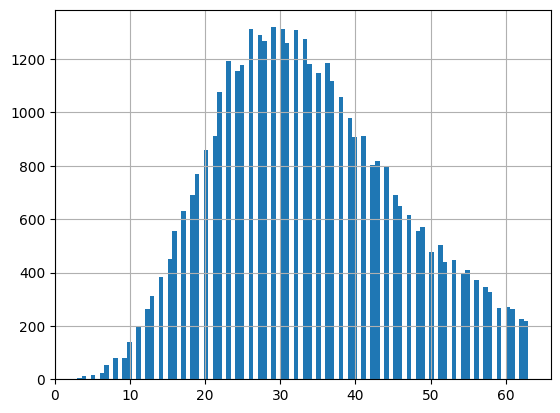

In [12]:
lengths = metadata["elsa_phone"].apply(len)
lengths.hist(bins=100)

In [13]:
MAX_LENGTH = 66

print(metadata.shape)
metadata = metadata[lengths<MAX_LENGTH-1]
print(metadata.shape)

(40340, 13)
(40340, 13)


### Extract alignment

In [14]:
def preprocess_alignments(alignment):
    processed_alignment = []
    for phone, start, duration in alignment:
        if phone == "SIL":
            continue
        phone = phone.split("_")[0]
        processed_alignment.append([phone, start, duration])
    
    return processed_alignment

In [15]:
with open(f'{out_dir}/alignment', "w", encoding="utf-8") as f:
    for index in tqdm(metadata.index):
        _id = metadata["id"][index]
        _alignment = metadata["alignment"][index]

        _alignment = preprocess_alignments(_alignment)

        _alignment= json.dumps(_alignment, ensure_ascii=False)
        
        f.write(f'{_alignment}\n')

100%|██████████| 40340/40340 [00:00<00:00, 68525.72it/s]


### Extract id

In [16]:
with open(f'{out_dir}/id', "w", encoding="utf-8") as f:
    for index in tqdm(metadata.index):
        _id = metadata["id"][index]
        
        f.write(f'{_id}\n')

100%|██████████| 40340/40340 [00:00<00:00, 507554.07it/s]


### Extract gop feature

In [17]:
gop_features = []

for index in tqdm(metadata.index):
    _id = metadata["id"][index]
    gop = gops[_id]

    padding = [[0,]*len(gop[0]),]*(MAX_LENGTH-len(gop))
    gop = gop.tolist() + padding
    gop = torch.tensor(gop)
    gop_features.append(gop)

gop_features = torch.stack(gop_features, dim=0)
gop_features = gop_features.numpy()
np.save(f'{out_dir}/gop.npy', gop_features)
gop_features = None

100%|██████████| 40340/40340 [00:12<00:00, 3278.16it/s]


RuntimeError: stack expects each tensor to be equal size, but got [65, 86] at entry 0 and [66, 86] at entry 14781

### Extract Relative Position

In [ ]:
path = "/data/codes/apa/train/exp/dicts/relative2id.json"
relative2id = json.load(open(path, "r", encoding="utf-8"))

In [ ]:
def convert_relative_position_to_id(relative_positions):
    ids = []
    for rel_pos in relative_positions:
        _id = relative2id[rel_pos]
        ids.append(_id)

    return ids
metadata["relative_positions"] = metadata["relative_positions"].apply(convert_relative_position_to_id)

In [ ]:
relative_positions = []

for index in metadata.index:
    relative_position = metadata["relative_positions"][index].copy()

    padding = [relative2id["PAD"],]*(MAX_LENGTH-len(relative_position))
    relative_position = relative_position + padding
    relative_position = torch.tensor(relative_position)
    relative_positions.append(relative_position)

relative_positions = torch.stack(relative_positions, dim=0)
relative_positions = relative_positions.numpy()
np.save(f'{out_dir}/relative_positions.npy', relative_positions)
relative_positions = None

### Extract sentence scores

In [ ]:
sentence_scores = []

for index in metadata.index:
    sentence_score = metadata["utterance_score"][index].copy()

    sentence_scores.append(sentence_score)

sentence_scores = torch.tensor(sentence_scores)
sentence_scores = sentence_scores.numpy()
print(sentence_scores.shape)
np.save(f'{out_dir}/sentence_scores.npy', sentence_scores)
sentence_scores = None

### Extract word scores

In [ ]:
word_scores = []

for index in metadata.index:
    word_score = metadata["word_scores"][index].copy()
    word_id = metadata["word_ids"][index].copy()

    word_score_in_phone_levels = []
    for wid in word_id:
        word_score_in_phone_levels.append(word_score[wid])

    padding = [-1,]*(MAX_LENGTH-len(word_score_in_phone_levels))
    word_score_in_phone_levels = word_score_in_phone_levels + padding
    word_score_in_phone_levels = torch.tensor(word_score_in_phone_levels)
    word_scores.append(word_score_in_phone_levels)

word_scores = torch.stack(word_scores, dim=0)
word_scores = word_scores.numpy()
print(word_scores.shape)
np.save(f'{out_dir}/word_scores.npy', word_scores)
word_scores = None

### Extract word ids

In [ ]:
word_ids = []

for index in metadata.index:
    word_id = metadata["word_ids"][index].copy()

    padding = [-1,]*(MAX_LENGTH-len(word_id))
    word_id = word_id + padding
    word_id = torch.tensor(word_id)
    word_ids.append(word_id)

word_ids = torch.stack(word_ids, dim=0)
word_ids = word_ids.numpy()
print(word_ids.shape)
np.save(f'{out_dir}/word_ids.npy', word_ids)
word_ids = None

### Extract duration feature

In [ ]:
durations = []

for index in metadata.index:
    duration = metadata["duration"][index].copy()

    padding = [0, ]*(MAX_LENGTH-len(duration))

    duration += padding
    duration = torch.tensor(duration)
    durations.append(duration)

durations = torch.stack(durations, dim=0)
durations = durations.numpy()
np.save(f'{out_dir}/duration.npy', durations)
durations = None

### Extract phone scores

In [ ]:
phone_scores = []

for index in metadata.index:
    phone_score = metadata["phone_scores"][index].copy()

    padding = [-1, ]*(MAX_LENGTH-len(phone_score))

    phone_score += padding
    phone_score = torch.tensor(phone_score)
    phone_scores.append(phone_score)

phone_scores = torch.stack(phone_scores, dim=0)
phone_scores = phone_scores.numpy()
np.save(f'{out_dir}/phone_scores.npy', phone_scores)
phone_scores = None

### Extract phone ids

In [ ]:
phone_dict_path =  "/data/codes/apa/train/exp/dicts/phone_dict.json"
with open(phone_dict_path, "r", encoding="utf-8") as f:
    phone_dict = json.load(f)

In [ ]:
phone_ids = []

pad_token_id = phone_dict["PAD"]
for index in metadata.index:
    phoneme = metadata["elsa_phone"][index].copy()

    phoneme = [re.sub("\d", "", phn) for phn in phoneme]
    phoneme = [phone_dict[phn] for phn in phoneme]
    padding = [pad_token_id, ]*(MAX_LENGTH-len(phoneme))

    phoneme += padding
    phone_ids.append(torch.tensor(phoneme))

phone_ids = torch.stack(phone_ids, dim=0)
phone_ids = phone_ids.numpy()
np.save(f'{out_dir}/phone_ids.npy', phone_ids)
phone_ids = None

### Extract WavLM Feature

In [ ]:
%cd /data/codes/apa/train
import torch
from src.models.wavlm_model import WavLM, WavLMConfig
from tqdm import tqdm
import librosa
import pandas as pd
import json

In [ ]:
pretrained_path = "/data/codes/apa/train/exp/torch/wavlm-base+.pt"
checkpoint = torch.load(pretrained_path)

config = WavLMConfig(checkpoint['cfg'])
model = WavLM(config).eval().cuda()
model.load_state_dict(checkpoint['model'])

In [ ]:
def extract_feature(alignment, features):
    index = 0
    phonemes = []
    indices = -1 * torch.ones(alignment[-1][1] + alignment[-1][2])
    for phoneme, start_frame, duration in alignment:
        if phoneme == "SIL":
            continue
        end_frame = start_frame + duration
        indices[start_frame:end_frame] = index
        phonemes.append(phoneme)
        index += 1

    if -1 in indices:
        indices[indices==-1] = indices.max() + 1

        indices = torch.nn.functional.one_hot(indices.long(), num_classes=int(indices.max().item())+1).cuda()
        indices = indices / indices.sum(0, keepdim=True)
    
        if features.shape[0] != indices.shape[0]:
            features = features[0:indices.shape[0]]
        features = torch.matmul(indices.transpose(0, 1), features)

        return features[:-1].cpu(), phonemes
    
    else:
        indices[indices==-1] = indices.max() + 1

        indices = torch.nn.functional.one_hot(indices.long(), num_classes=int(indices.max().item())+1).cuda()
        indices = indices / indices.sum(0, keepdim=True)
    
        if features.shape[0] != indices.shape[0]:
            features = features[0:indices.shape[0]]
        features = torch.matmul(indices.transpose(0, 1), features)

        return features.cpu(), phonemes

In [ ]:
wavlm_features = []
for index in tqdm(metadata.index):
    audio_path = metadata["audio_path"][index]
    alignment = metadata["alignment"][index]

    wav, sr = librosa.load(audio_path, sr=16000)

    input_values = torch.from_numpy(wav).unsqueeze(0).cuda()
    with torch.no_grad():
        features = model.extract_features(input_values)[0]
        if index % 1000:
            torch.cuda.empty_cache()

    index = torch.arange(features.shape[1]).unsqueeze(-1)
    expanded_index = index.expand((-1, 2)).flatten()
    features = features[0][expanded_index]

    features, phonemes = extract_feature(alignment, features)
    if len(features) != len(phonemes):
        print(metadata["id"][index])

    features = torch.concat([features, torch.zeros(MAX_LENGTH-len(features), 768)], axis=0)
    wavlm_features.append(features.unsqueeze(0).numpy())

wavlm_features = np.row_stack(wavlm_features)
np.save(f'{out_dir}/wavlm_features.npy', wavlm_features)
wavlm_features = None

### build index dataset

In [ ]:
%cd /data/codes/apa/train/
from tqdm import tqdm
import numpy as np
import pickle
import os

from src.dataset import (
    IndexedDataset,
    IndexedDatasetBuilder
)

In [ ]:
npy_path = f"{out_dir}/wavlm_features.npy"
indexed_path = f'{out_dir}/wavlm_features'

data = np.load(npy_path)
builder = IndexedDatasetBuilder(indexed_path)

for index in tqdm(range(data.shape[0])):
    builder.add_item(item=data[index])

builder.finalize()